In [132]:
import numpy as np
import mne
import matplotlib
%matplotlib inline
#%matplotlib qt
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import glob, os
import scipy
import pickle
import networkx as nx
import preprocessing as prep
from itertools import permutations
import pandas as pd
from tqdm import tqdm

from epoch_connectivity import ConnEEG as cnegg
from epoch_connectivity import ConnectionMatrices as cm
from epoch_connectivity import Connectomes as cntms

from epoch_connectivity.utils import FrequencyBand, only_EEG_channels

import mne_connectivity as mnecon

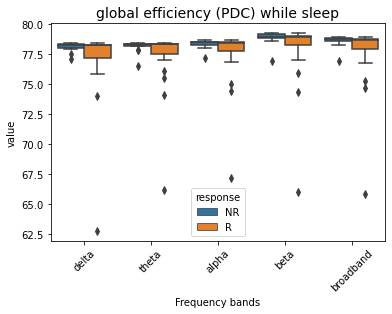

In [181]:
def get_column_name(measure_used, record_status, frequency_band, graph_measure=None):
    if measure_used is not 'wPLI':
        return measure_used+'_'+frequency_band+'_'+record_status+'_'+graph_measure
    else:
        return measure_used+'_'+frequency_band+'_'+record_status+'_'+'MEAN_SYNCH'
    
    
def r_nr_asarrays(column_name, full_dataframe):
    responders = np.array(full_dataframe.loc[full_dataframe["response"] == "R", column_name])
    non_responders = np.array(full_dataframe.loc[full_dataframe["response"] == "NR", column_name])
    return responders, non_responders

def get_reduced_df(full_dataframe, measure_used, record_status, graph_measure=None):
    columns_to_get = []
    for frequency_band in ['delta', 'theta', 'alpha', 'beta', 'broadband']:
        columns_to_get.append(get_column_name(measure_used=measure_used, graph_measure=graph_measure,
                                              record_status=record_status, frequency_band=frequency_band))
    columns_to_get.append('response')
    return full_dataframe[columns_to_get]

def get_plot_title(measure_used, record_status, graph_measure=None):
    g_measure_name = {'GE':'Global efficiency', 'MOD':'Modularity', 'GRC':'Global reaching centrality',
                      'DA':'Degree assortativity', 'AVGCC':'Average clustering coefficient', 'MEAN_SYCNH':'Mean synchronization'}
    rec_status_name = {'SLEEP':'sleep', 'AWAKE':'awake'}
    if measure_used is not 'wPLI':
        return g_measure_name[graph_measure]+' ('+measure_used+') while '+rec_status_name[record_status], 'Mean wPLI value'
    else:
        return 'wPLI mean synchronization while '+rec_status_name[record_status], g_measure_name[graph_measure]+' value'
    
def plot_boxplot(full_dataframe, measure_used, record_status, graph_measure=None):
    reduced_df = get_reduced_df(full_dataframe=full_dataframe, measure_used=measure_used, graph_measure=graph_measure,
                                record_status=record_status)
    bp = sns.boxplot(x="variable", y="value", hue="response", data=pd.melt(reduced_df, id_vars='response'))
    bp.set_xticklabels(['delta', 'theta', 'alpha', 'beta', 'broadband'])
    title, y_label = 
    plt.xlabel('Frequency bands')
    plt.title(get_plot_title(measure_used=measure_used, record_status=record_status, graph_measure=graph_measure), fontsize=14)
    plt.xticks(rotation=45)
    if measure_used = 'wPLI':
        plt.ylabel('Mean wPLI value')
    else:
        plt.ylabel('')
    return

#column_name = get_column_name('PDC', 'DA', 'SLEEP', 'beta')
#a, b = r_nr_asarrays(column_name, full_df)

plot_boxplot(full_df, 'PDC', 'SLEEP', 'GE')
#get_reduced_df(full_dataframe=full_df, measure_used='wPLI', record_status='SLEEP')

In [157]:
scipy.stats.ttest_ind(a, b)

Ttest_indResult(statistic=1.1257847385927788, pvalue=0.26814073889267964)

In [141]:
response = pd.read_csv('response.csv', sep=';') # Read the response data
features = pd.read_csv('no_thresh_08042022.csv', index_col=0) # Read the features dataframe
full_df = pd.merge(features, response, on='patient', how='outer') # Join the two dataframes
full_df = full_df.dropna() # Drop the NaN values

#
full_df.loc[full_df["response"] == "RP", "response"] = "R"
full_df.loc[full_df["response"] == "PR", "response"] = "R"
#full_df.loc[full_df["response"] == "R", "response"] = "R"
#full_df.loc[full_df["response"] == "NR", "response"] = "0"

In [120]:
np.array(full_df.loc[full_df["response"] == "NR", "DTF_delta_AWAKE_GRC"])

array([1.31915147, 0.85499827, 0.64942255, 1.19929286, 2.52991171,
       1.40908276, 0.75640702, 0.27955426, 0.92620592, 1.42626271,
       0.46567199, 0.96136907, 1.00927089, 0.31064104])

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'DTF_delta_SLEEP_GE'),
  Text(1, 0, 'DTF_theta_SLEEP_GE'),
  Text(2, 0, 'DTF_alpha_SLEEP_GE'),
  Text(3, 0, 'DTF_beta_SLEEP_GE'),
  Text(4, 0, 'DTF_broadband_SLEEP_GE'),
  Text(5, 0, 'PDC_delta_SLEEP_GE'),
  Text(6, 0, 'PDC_theta_SLEEP_GE'),
  Text(7, 0, 'PDC_alpha_SLEEP_GE'),
  Text(8, 0, 'PDC_beta_SLEEP_GE'),
  Text(9, 0, 'PDC_broadband_SLEEP_GE')])

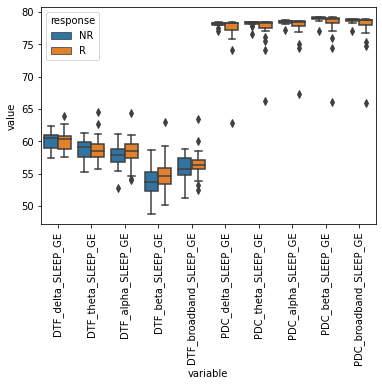

In [145]:
#aux = full_df.filter(regex='(?=.*SLEEP_MEAN_SYNCH$)|(?=.*response)',axis=1)
aux = full_df.filter(regex='(?=.*SLEEP_GE$)|(?=.*response)',axis=1)

#sns.boxplot(x="response", y="wPLI_theta_SLEEP_MEAN_SYNCH", hue="response", data=aux)
sns.boxplot(x="variable", y="value", hue="response", data=pd.melt(aux, id_vars='response'))
plt.xticks(rotation=90)

#pd.melt(aux, id_vars='response')

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'DTF_delta_AWAKE_GE'),
  Text(1, 0, 'DTF_theta_AWAKE_GE'),
  Text(2, 0, 'DTF_alpha_AWAKE_GE'),
  Text(3, 0, 'DTF_beta_AWAKE_GE'),
  Text(4, 0, 'DTF_broadband_AWAKE_GE'),
  Text(5, 0, 'PDC_delta_AWAKE_GE'),
  Text(6, 0, 'PDC_theta_AWAKE_GE'),
  Text(7, 0, 'PDC_alpha_AWAKE_GE'),
  Text(8, 0, 'PDC_beta_AWAKE_GE'),
  Text(9, 0, 'PDC_broadband_AWAKE_GE')])

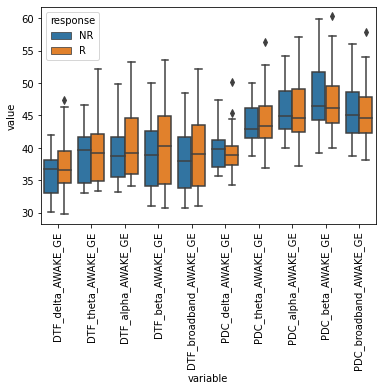

In [114]:
#aux = full_df.filter(regex='(?=.*SLEEP_MEAN_SYNCH$)|(?=.*response)',axis=1)
aux = full_df.filter(regex='(?=.*AWAKE_GE$)|(?=.*response)',axis=1)

#sns.boxplot(x="response", y="wPLI_theta_SLEEP_MEAN_SYNCH", hue="response", data=aux)
sns.boxplot(x="variable", y="value", hue="response", data=pd.melt(aux, id_vars='response'))
plt.xticks(rotation=90)

#pd.melt(aux, id_vars='response')

<AxesSubplot:xlabel='response', ylabel='wPLI_alpha_SLEEP_MEAN_SYNCH'>

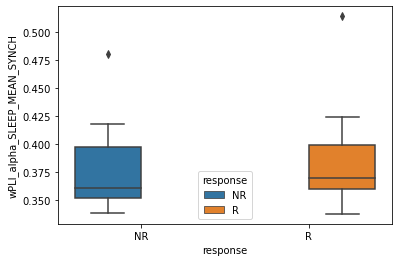

In [75]:
sns.boxplot(x="response", y="wPLI_alpha_SLEEP_MEAN_SYNCH", hue="response", data=aux)

In [35]:
pd.melt(aux, id_vars='response')

,response,variable,value
0,NR,wPLI_delta_AWAKE_MEAN_SYNCH,0.374143
1,R,wPLI_delta_AWAKE_MEAN_SYNCH,0.353198
2,R,wPLI_delta_AWAKE_MEAN_SYNCH,0.390946
3,R,wPLI_delta_AWAKE_MEAN_SYNCH,0.384421
4,R,wPLI_delta_AWAKE_MEAN_SYNCH,0.396470
...,...,...,...
125,NR,wPLI_broadband_AWAKE_MEAN_SYNCH,0.398500
126,RP,wPLI_broadband_AWAKE_MEAN_SYNCH,0.346520
127,R,wPLI_broadband_AWAKE_MEAN_SYNCH,0.397728
128,R,wPLI_broadband_AWAKE_MEAN_SYNCH,0.337260
